In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import os
import graphviz

# Downloading the Data

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
df = pd.read_csv(url, names = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'])

# Pandas Profiling Report

In [3]:
prof = ProfileReport(df)
prof

Summarize dataset:   0%|          | 0/36 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Some immediate things jump out to me in this report which need to be highlighted. Number one, the veil-type variable is constant and can therefore be removed. Additionally there are a couple feature pairs that show very high Cramer's V statistics which we will address later (i.e. gill attachment and veil-color, and odor and class)

In [4]:
df = df.drop('veil-type', axis = 1)

# Label Encode the Data Set

In [5]:
encoded_df = df.copy()
encoded_df = encoded_df.astype('category')
labelencoder=LabelEncoder()
for column in encoded_df.columns:
    encoded_df[column] = labelencoder.fit_transform(encoded_df[column])

# Violin Plot

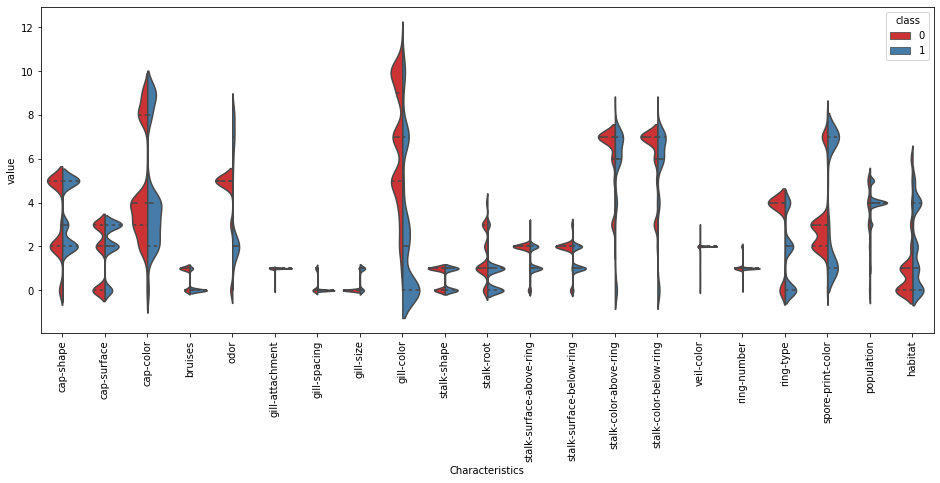

In [6]:
%matplotlib inline
df_div = pd.melt(encoded_df, "class", var_name="Characteristics")
fig, ax = plt.subplots(figsize=(16,6))
p = sns.violinplot(ax = ax, x="Characteristics", y="value", hue="class", split = True, data=df_div, inner = 'quartile', palette = 'Set1')
df_no_class = encoded_df.drop(['class'],axis = 1)
p.set_xticklabels(rotation = 90, labels = list(df_no_class.columns));
plt.show()

### The above violin plot gives us a good idea of which variables will be important in predicting whether a mushroom is poisonous or edible. For example, odor, gill color, and spore-print-color appear very important as there are distinct peaks for both classes without a mirrored peak for the other class. Other features appear very unhelpful, such as stalk-shape which is relatively mirrored and therefore as likely to poison us as feed us.

# Correlation Heatmap

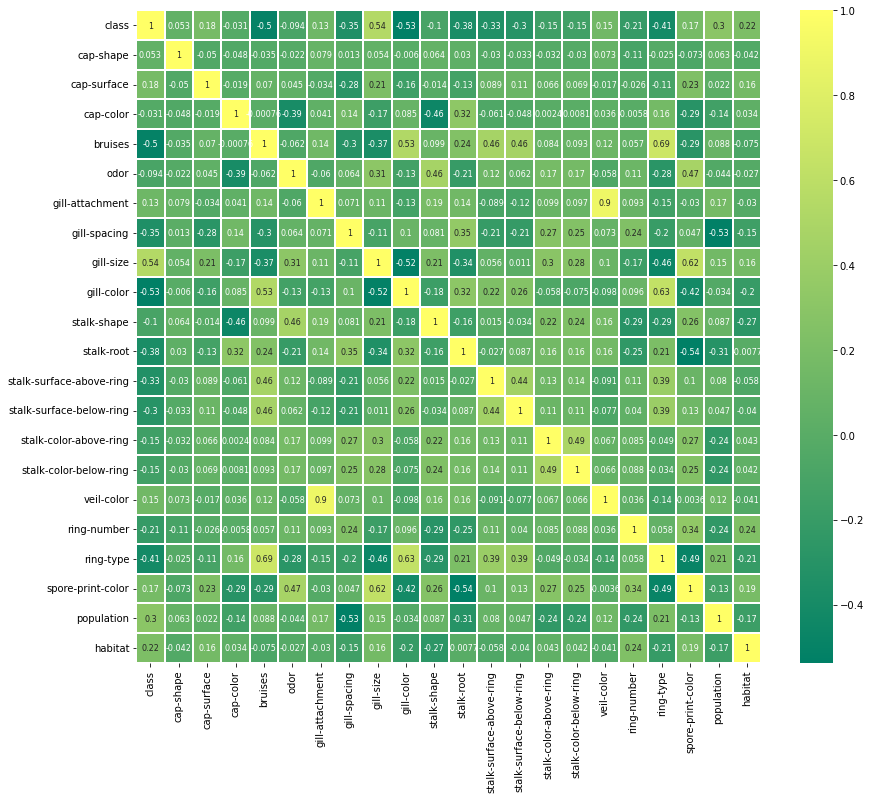

In [7]:
plt.figure(figsize=(14,12))
sns.heatmap(encoded_df.corr(),linewidths=.1,cmap="summer", annot=True, annot_kws={"size": 8});
plt.yticks(rotation=0);
plt.show()

### Strong negative correlation with class is a feature we are looking at for importance, because poisonous was coded as 1 and edible as 0 when we label encoded our dataframe. It looks like gill-color and bruises will be important here.  

## So from this point we are going to apply classification techniques with the class variable as the desired output and determine which classification technique is the most accurate. This will help us with the first and most important element of a stew: making one that won't kill us. 

# Decision Tree Classifier-----------------------------------------------------------------------------

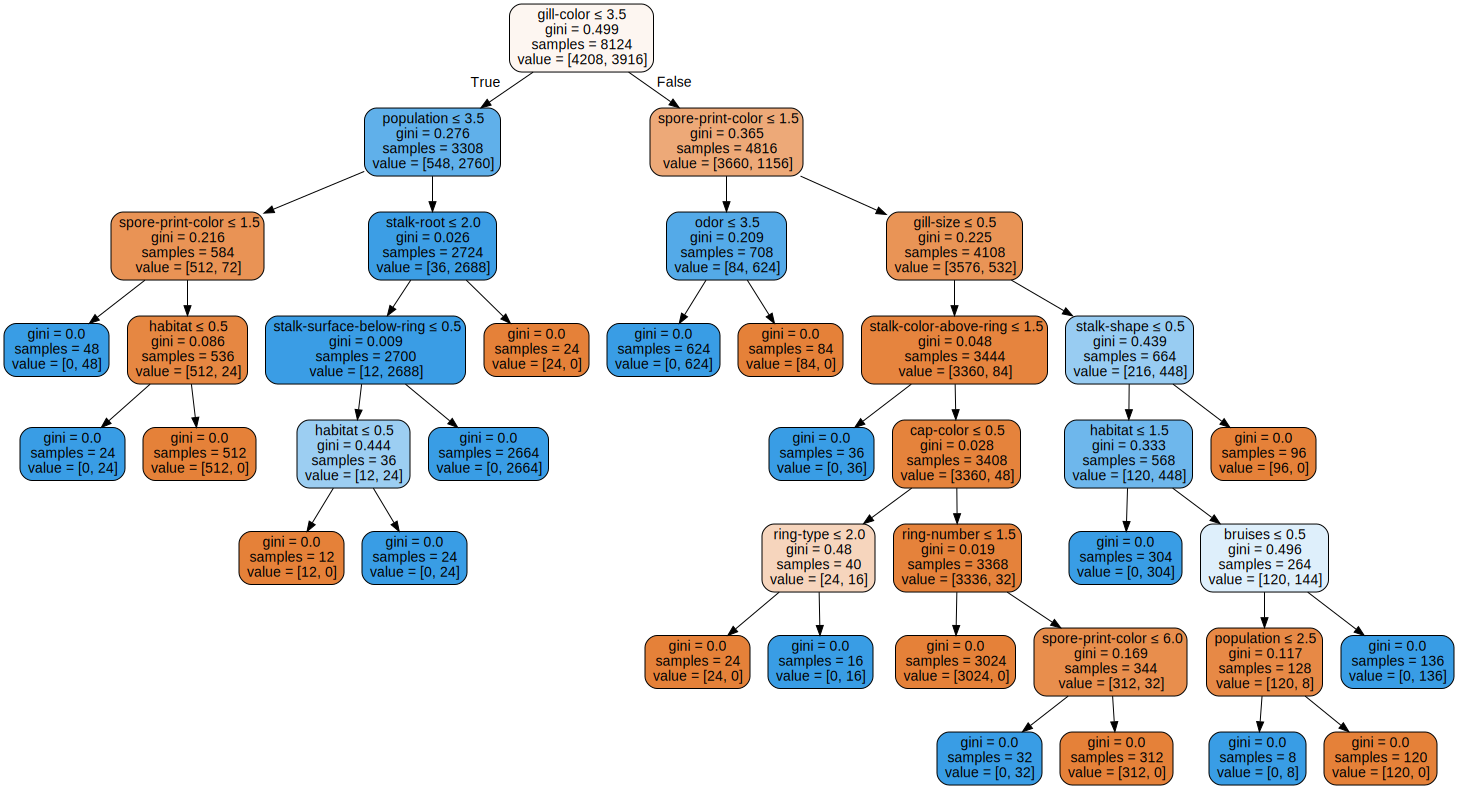

In [8]:
X = encoded_df.drop('class', axis=1)
y = encoded_df['class']
dt = DecisionTreeClassifier()
dt.fit(X, y)

os.environ["PATH"] += os.pathsep + 'C:/Users/840\ G5\ eval/Desktop/DST1/VirtualEnvironment/lib/python3.8/site-packages/graphviz/'

dot_data = export_graphviz(dt, out_file=None, 
 feature_names=X.columns, 
 filled=True, rounded=True, 
 special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("DecisionTree.gv.pdf")
graph

### Now lets examine feature importance

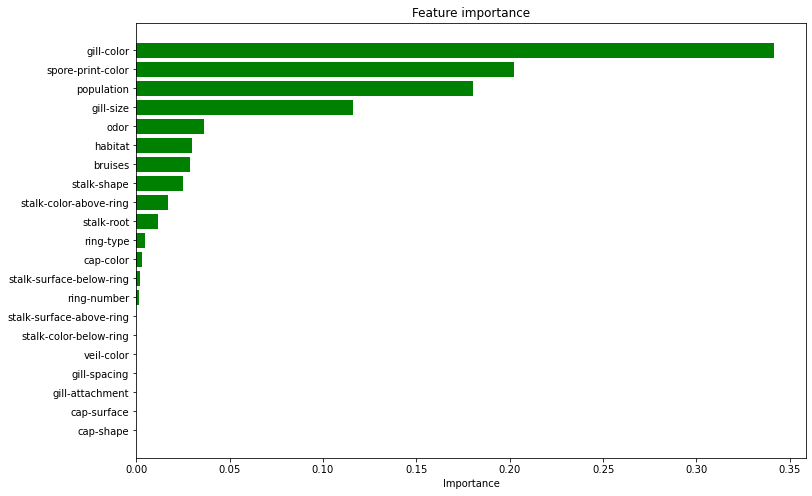

In [9]:
features_list = X.columns.values
feature_importance = dt.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(12,8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color ="green")
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importance')
plt.show()

### It turns out that despite odor showing the highest Cramer's V statistic for the class attribute (under the pandas profiling report), the 2nd and 3rd highest Cramer's V statistics were more important, with gill-color being the most important classifier for predicting class, and spore-print-color the second most important. We knew gill color would be important because of the correlation heatmap. 

## The Predictions

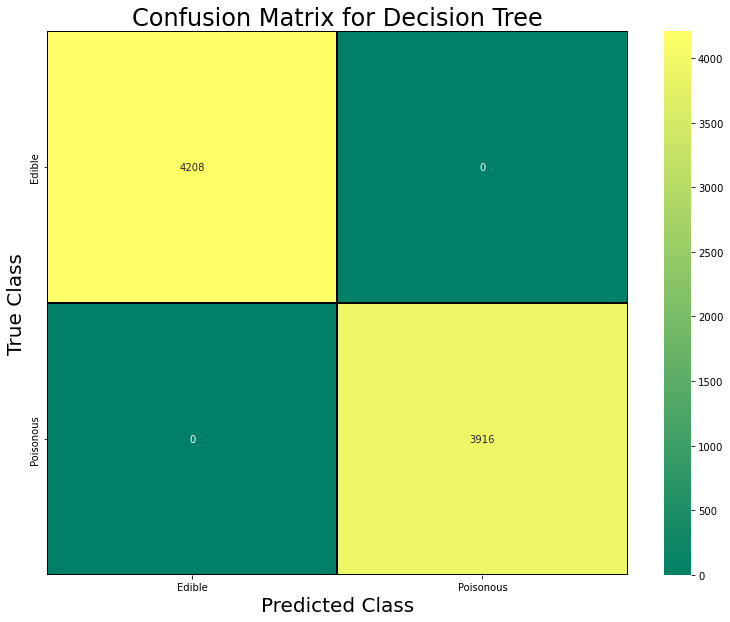

In [10]:
y_pred = dt.predict(X)

def conf_mat(y, y_pred, classif):
    
    cm = confusion_matrix(y, y_pred)
    x_axis_labels = ["Edible", "Poisonous"]
    y_axis_labels = ["Edible", "Poisonous"]
    f, ax = plt.subplots(figsize =(13,10))
    sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="summer", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    plt.xlabel("Predicted Class", fontsize=20)
    plt.ylabel("True Class", fontsize = 20)
    plt.title('Confusion Matrix for {}'.format(classif), fontsize=24)
    plt.show()
    
conf_mat(y, y_pred, "Decision Tree")

### Starting off strong with 100% accuracy predicted with the decision tree classifier. We will still look at some other classification options, but this is a strong start. 

# Random Forest Classification--------------------------------------------------------------------

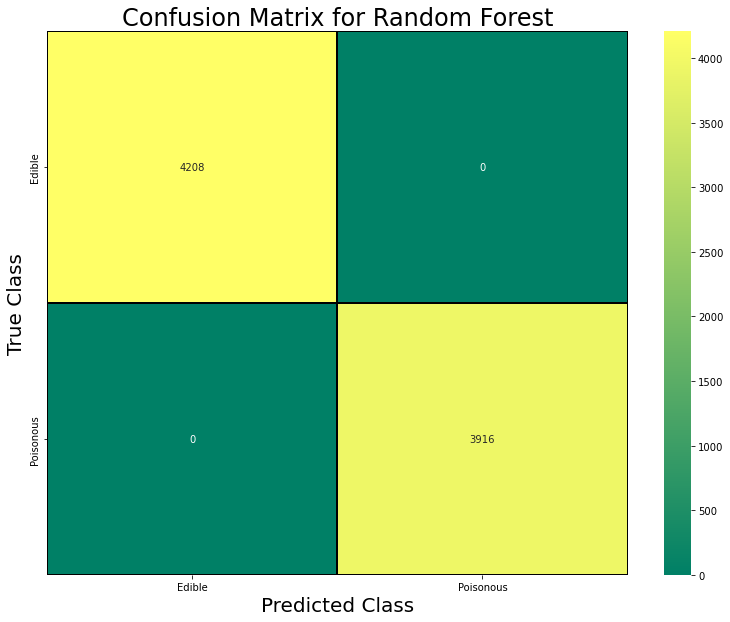

In [11]:
rf = RandomForestClassifier(n_estimators=100, random_state=19)
rf.fit(X, y)
y_pred_edible = rf.predict(X)

conf_mat(y, y_pred_edible, "Random Forest")

### Another 100% accuracy for Random Forest Regression, and another solid contender for determing whether a mushroom is poisonous or edible, but lets try a few more. 

# KNN Classification------------------------------------------------------------------------------------

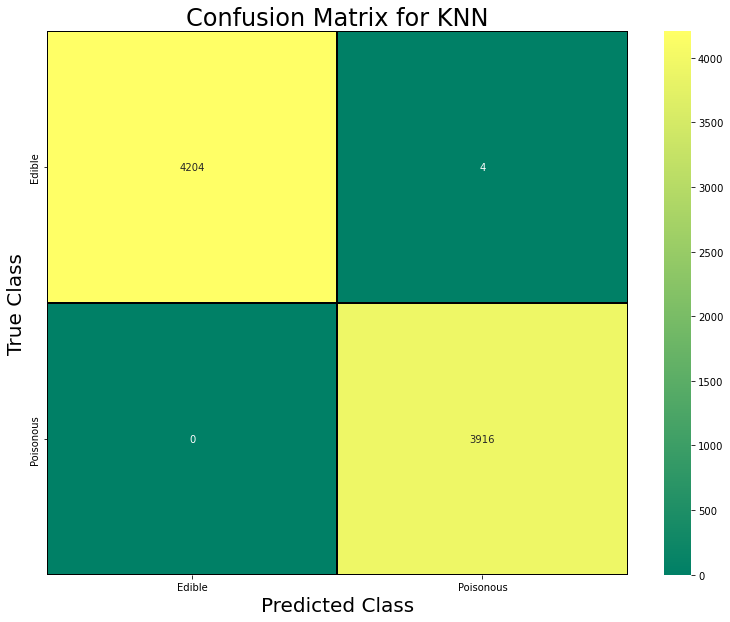

In [12]:
best_Kvalue = 0
best_score = 0
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X.values, y.values)
    if knn.score(X.values, y.values) > best_score:
        best_score = knn.score(X.values, y.values)
        best_Kvalue = i
        
y_pred = knn.predict(X.values)
conf_mat(y, y_pred, "KNN")

### We have our first classification model that isn't 100% accurate. It is very accurate, with only 4 edible mushrooms incorrectly predicted as posionous (better than the other way around), but since we already have 2 100% accurate models we won't consider KNN classification any further. 

# Support Vector Classification---------------------------------------------------------------------

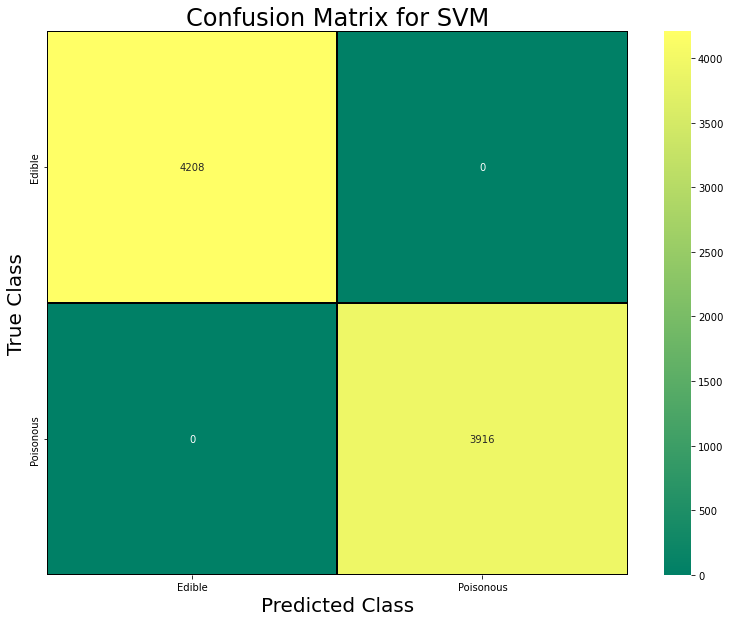

In [13]:
svm = SVC(random_state=19, gamma="auto")
svm.fit(X, y)
y_pred = svm.predict(X)
conf_mat(y, y_pred, "SVM")

### aaaaaand another 100% accurate classification method. It turns out this dataset is just very easy to predict correctly with classification methods, probably why it is a classic data science homework. Lets do one more classification technique.

# Naive Bayes Classification-------------------------------------------------------------------------

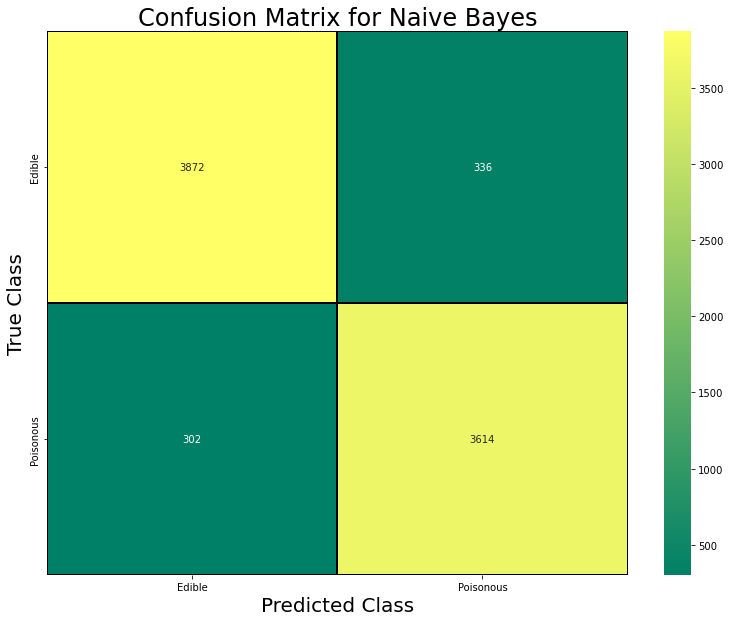

In [14]:
nb = GaussianNB()
nb.fit(X, y)
y_pred = nb.predict(X)

conf_mat(y, y_pred, "Naive Bayes")

### Finally we do run in to a classification method that does not hit extremely high predictive accuracy. Its easy to throw out Naive Bayes classification at this point, leaving us with 3 methods that hit 100% accuracy: Decision tree classification, Random Forest Classification, and Support Vector Classification. 

### I am going to use random forest regression from this point onward, obviously because mushrooms grow in the forest and when choosing between models that all hit 100% accuracy, that seems as good a reason as any. Now that we can classify a mushroom as poisonous or edible, we need to decide how to classify a mushroom as pleasant smelling and visually appealing. 

### Both smell and visual appeal are rather subjective, but I am going to start with visual appeal. One thing I personally never want on my food is bruises, so I will change the output variable from class to bruises and use random forest regression and determine if I can build a model that will accurately predict the presence of bruises.

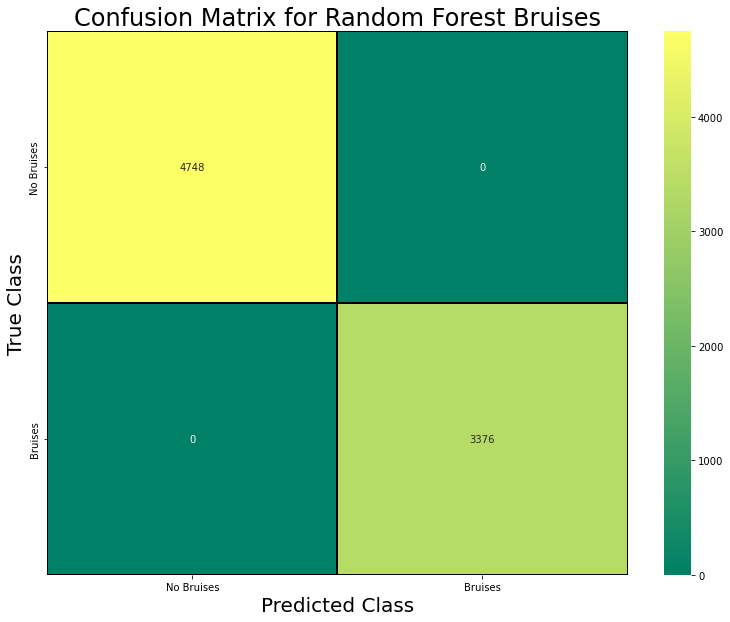

In [15]:
X = encoded_df.drop('bruises', axis = 1)
y = encoded_df['bruises']

rf = RandomForestClassifier(n_estimators=100, random_state=19)
rf.fit(X, y)
y_pred_bruises = rf.predict(X)

cm = confusion_matrix(y, y_pred_bruises)
x_axis_labels = ["No Bruises", "Bruises"]
y_axis_labels = ["No Bruises", "Bruises"]
f, ax = plt.subplots(figsize =(13,10))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="summer", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("Predicted Class", fontsize=20)
plt.ylabel("True Class", fontsize = 20)
plt.title('Confusion Matrix for Random Forest Bruises', fontsize=24)
plt.show()

### Once again, our random forest classification predicts bruises with 100% accuracy! This is good news so far, now lets turn our attention to nice smelling mushrooms. The odor category contains 9 different smells: almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p, spicy=s. We decided almond, anise, and none are good smells (or at least not detrimental) and all other smells do not contribute to a nice smelling stew. This allows us to binarize the odor column and perform our random forest regression again. 

In [16]:
good_smells = ['a', 'l', 'n']
for i in good_smells:
    df.loc[df.odor == i, "odor"] = 0
bad_smells = ['c', 'y', 'f', 'm', 'p', 's']
for i in bad_smells:
    df.loc[df.odor == i, "odor"] = 1     

encoded_df['binary_odor'] = df['odor'].astype('category')

### Odor is now binarized, lets run our classification method

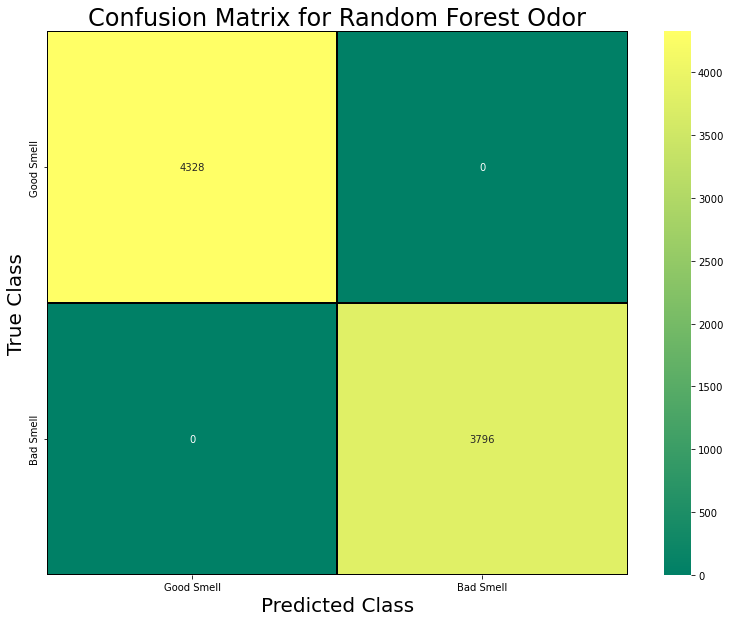

In [17]:
X = encoded_df.drop(['odor', 'binary_odor'], axis = 1)
y = encoded_df['binary_odor']

rf = RandomForestClassifier(n_estimators=100, random_state=19)
rf.fit(X, y)
y_pred_odor = rf.predict(X)

cm = confusion_matrix(y, y_pred_odor)
x_axis_labels = ["Good Smell", "Bad Smell"]
y_axis_labels = ["Good Smell", "Bad Smell"]
f, ax = plt.subplots(figsize =(13,10))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="summer", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("Predicted Class", fontsize=20)
plt.ylabel("True Class", fontsize = 20)
plt.title('Confusion Matrix for Random Forest Odor', fontsize=24)
plt.show()

### Now we have three random forest classification models, one that predicts whether a mushroom is poisonous or edible, one that predicts whether a mushroom has bruises or not, and one that predicts whether a mushroom smells pleasing or not. All 3 have thus far predicted with 100% accuracy. Ordinarily we would have built these models on training data and then applied them to new data to build a stew from unknown variables, but since we did not do a train/test split we will instead simply take the overlapping observations that fall into the "good" side of all three variables and use those mushrooms to make our stew!

In [18]:
df['edible_prediction'] = y_pred_edible
df['bruises_prediction'] = y_pred_bruises
df['odor_prediction'] = y_pred_odor

stew_df = df.loc[(df['edible_prediction'] == 0) & (df['bruises_prediction'] == 0) & (df['odor_prediction'] == 0)]
stew_df = stew_df.drop(['edible_prediction', 'bruises_prediction', 'odor_prediction'], axis=1)
stew_df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,...,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456
unique,1,5,3,6,1,1,2,2,2,9,...,4,4,3,3,3,2,3,7,6,5
top,e,x,s,n,f,0,f,w,b,p,...,s,s,w,w,w,o,e,n,s,g
freq,1456,604,728,536,1456,1456,1264,1104,1264,324,...,888,840,1248,1200,1264,1152,816,480,528,1056


# Conclusion----------------------------------------------------------------------------------------------

### We are left with a dataframe that contains 1456 individual mushrooms which fit our criteria and could be added to our stew. As you can see above, all mushrooms are of the edible class, with no bruises, and a pleasant smelling odor. Random Forest Classification predicted each of our chosen outputs with 100% accuracy.